In [1]:
data_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics/data/single-cell/exploratory"
working_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics"

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(working_dir)

import yaml
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import numpy as np
import scanpy as sc
from scipy import sparse
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import font_manager
import pandas as pd

from utils.utils import *
from utils.plotting import *

sc.settings.verbosity = 0
sc.settings._vector_friendly = True
font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "arial"
plt.rcParams['font.size'] = 12

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Load data

In [3]:
path = os.path.join(
    data_dir, "ANCA_exploratory_27PK27PB_Tcells_HarmonyR_annotated.h5mu"
)
mudata = md.read_h5mu(path)
mod_rna = mudata.mod["rna"]
mod_cite = mudata.mod["cite"]

path = os.path.join(data_dir, "ANCA_exploratory_27PK27PB_CD4Teff_annotated.h5mu")
mudata_cd4 = md.read_h5mu(path)
mod_rna_cd4 = mudata_cd4.mod["rna"]
mod_cite_cd4 = mudata_cd4.mod["cite"]

path = os.path.join(data_dir, "ANCA_exploratory_27PK27PB_CD8Teff_annotated.h5mu")
mudata_cd8 = md.read_h5mu(path)
mod_rna_cd8 = mudata_cd8.mod["rna"]
mod_cite_cd8 = mudata_cd8.mod["cite"]

In [4]:
mod_rna.obs["cell_type_v1_merged"] = mod_rna.obs["cell_type_v1"].astype(str)
mod_rna.obs.loc[mod_rna_cd4.obs_names, "cell_type_v1_merged"] = mod_rna_cd4.obs[
    "cell_type_fine"
].astype(str)

mod_rna.obs.loc[mod_rna_cd8.obs_names, "cell_type_v1_merged"] = mod_rna_cd8.obs[
    "cell_type_fine"
].astype(str)

mod_rna.obs["cell_type_v1_merged"] = mod_rna.obs["cell_type_v1_merged"].astype(
    "category"
)

In [5]:
# remove any obs that are not sub labeled
teff_obs_names = mod_rna[
    mod_rna.obs["cell_type_v1"].isin(["CD4+ Teff", "CD8+ Teff"])
].obs_names

In [6]:
extra_obs_names = list(
    (set(teff_obs_names) - set(mod_rna_cd4.obs_names)) - set(mod_rna_cd8.obs_names)
)
mod_rna = mod_rna[~mod_rna.obs_names.isin(extra_obs_names)].copy()

In [7]:
mod_rna.obs.head()

,patient,sample,tissue,cell_type_yu,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,...,leiden_1.3,leiden_1.4,leiden_1.5,leiden_1.6,leiden_1.7,leiden_1.8,leiden_1.9,cell_type,cell_type_v1,cell_type_v1_merged
E016K_AAACGGGAGATCGGGT,E016,E016K,K,CD4/CD8 stressed,580,580,1136.0,18.0,1.584507,259.0,...,7,7,9,9,9,8,8,CD4+/CD8+ stressed,stressed T cells,stressed T cells
E016K_AAAGATGCACATCCAA,E016,E016K,K,CD8 EM/RM,750,749,1546.0,46.0,2.975420,367.0,...,4,4,4,4,4,4,4,CD8+ EM/RM,CD8+ Teff,Tc1
E016K_AAAGATGTCCTTCAAT,E016,E016K,K,CD8 EM/RM,657,657,1452.0,29.0,1.997245,384.0,...,4,4,4,4,4,4,4,CD8+ EM/RM,CD8+ Teff,Tc1
E016K_AACCATGGTGACTCAT,E016,E016K,K,CD8 EM/RM,887,887,2068.0,58.0,2.804642,553.0,...,4,4,4,4,4,4,4,CD8+ EM/RM,CD8+ Teff,NKT/CTL
E016K_AACCGCGGTTACCAGT,E016,E016K,K,CD8 EM/RM,818,818,2056.0,67.0,3.258755,564.0,...,4,14,15,16,16,16,16,CD8+ EM/RM,CD8+ Teff,NKT/CTL


## Add anca subtype information

In [8]:
type_mapping = {
    "E016": "MPO",
    "E013": "MPO",
    "E025": "MPO",
    "E022": "MPO",
    "E014": "MPO",
    "E010": "MPO",
    "E018": "PR3",
    "E017": "MPO",
    "E003": "PR3",
    "E008": "PR3",
    "E024": "MPO",
    "E026": "PR3",
    "E004": "MPO",
    "E002": "MPO",
    "E012": "MPO",
    "E021": "PR3",
    "E005": "MPO",
    "E001": "MPO",
    "E020": "MPO",
    "E023": "MPO",
    "E006": "PR3",
    "E011": "MPO",
    "E007": "PR3",
    "E019": "MPO",
    "E009": "MPO",
    "E027": "MPO",
    "E015": "PR3",
}

In [9]:
mod_rna.obs["type"] = mod_rna.obs["patient"].map(type_mapping)

## Overview

... storing 'type' as categorical


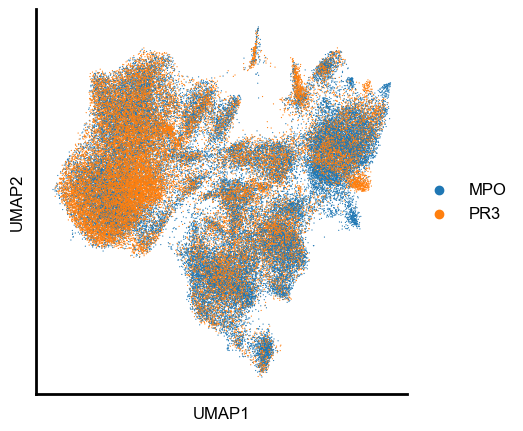

In [10]:
plot_umap(
    mod_rna,
    color="type",
    # palette=colors,
    figsize=(5.5, 5),
    title="",
    size=3,
    axes_fraction=1.0,
    save_path="figures/supp/exploratory_anca_type.pdf",
)

## Analyze T cell composition per subtype

In [11]:
celltype_col = "cell_type_v1"

celltype_map = dict(zip(mod_rna.obs["cell_type"], mod_rna.obs[celltype_col]))

color_map = {
    "CD4+ naive": "#1f77b4",
    "CD4+/CD8+ CM": "#ff7f0e",
    "NKT/CTL": "#279e68",
    "CD4+ EM/RM": "#d62728",
    "CD8+ EM/RM": "#aa40fc",
    "CD8+ CM/EM": "#8c564b",
    "CD4+/CD8+ stressed": "#e377c2",
    "Treg": "#b5bd61",
    "CD8+ naive": "#17becf",
    "MAIT": "#ffbb78",
    "Prolif.": "#98df8a",
    "NKT": "#aec7e8",
    "gdT": "#c5b0d5",
    "CD4+ CM": "#ff9896",
    "NK": "#c49c94",
}
color_map = {celltype_map[k]: v for k, v in color_map.items()}

order = [
    "CD4+ EM/RM",
    "CD8+ EM/RM",
    "CD4+ naive",
    "CD4+ CM",
    "CD8+ naive",
    "CD8+ CM/EM",
    "CD4+/CD8+ CM",
    "CD4+/CD8+ stressed",
    "Treg",
    "gdT",
    "MAIT",
    "NKT/CTL",
    "NKT",
    "NK",
    "Prolif.",
]
order = [celltype_map[x] for x in order]
colors = [color_map[x] for x in order]
orig_col = mod_rna.obs[celltype_col].copy()
mod_rna.obs["cell_type_umap"] = pd.Categorical(
    mod_rna.obs[celltype_col], categories=order, ordered=True
)

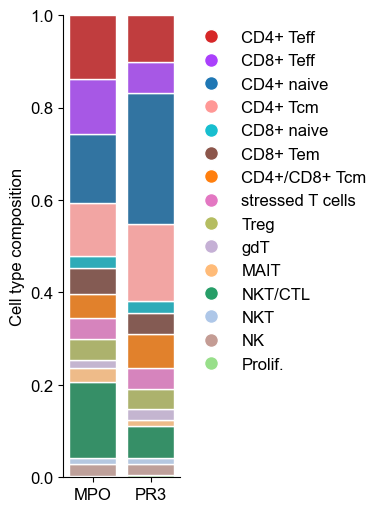

cell_type_umap,CD4+ Teff,CD8+ Teff,CD4+ naive,CD4+ Tcm,CD8+ naive,CD8+ Tem,CD4+/CD8+ Tcm,stressed T cells,Treg,gdT,MAIT,NKT/CTL,NKT,NK,Prolif.
type,,,,,,,,,,,,,,,
MPO,0.138652,0.117843,0.150247,0.113927,0.027413,0.055952,0.052087,0.043999,0.047045,0.016151,0.030459,0.163429,0.014922,0.025237,0.002636
PR3,0.102141,0.065705,0.283302,0.166317,0.027560,0.044353,0.073562,0.046302,0.043214,0.022611,0.013735,0.069873,0.012175,0.024681,0.004468


In [12]:
plot_key_compositon_for_groups(
    mod_rna,
    "type",
    "cell_type_umap",
    colors,
    order=order,
    figsize=(1.5, 6),
    bbox_to_anchor=(1, 1),
    xlabel=None,
    ylabel="Cell type composition",
    save_path="figures/supp/exploratory_anca_type_composition.pdf",
)

## Teff subtype composition

In [13]:
cmap_teff = {
    "Tc1": "#6600B4",
    "Tc17-like": "#840AE2",
    "Tc1-like": "#A228FF",
    "NKT/CTL": "#D2D2D2",
    "Th17": "#7B1717",
    "Th1": "#A91F1F",
    "Tfh": "#E0B093",
    "Th1-like": "#D62728",
}

labels_teff = [
    "Th17",
    "Th1",
    "Th1-like",
    "Tfh",
    "Tc1",
    "Tc1-like",
    # "Tc1-like",
    "Tc17-like",
    "NKT/CTL",
]

colors_teff = [cmap_teff[x] for x in labels_teff]
mod_rna_sub = mod_rna[
    mod_rna.obs["cell_type_v1"].isin(["CD8+ Teff", "CD4+ Teff"])
].copy()
mod_rna_sub.obs["cell_type_umap"] = pd.Categorical(
    mod_rna_sub.obs["cell_type_v1_merged"], categories=labels_teff, ordered=True
)

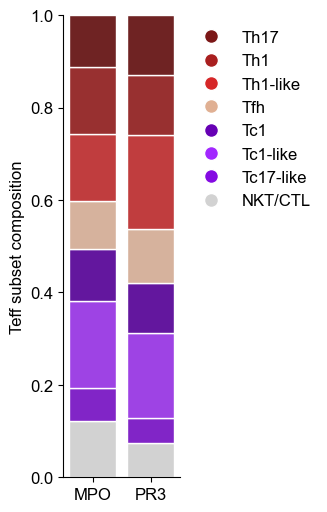

In [14]:
comp_data = plot_key_compositon_for_groups(
    mod_rna_sub,
    "type",
    "cell_type_umap",
    colors_teff,
    order=labels_teff,
    figsize=(1.5, 6),
    bbox_to_anchor=(1, 1),
    xlabel=None,
    ylabel="Teff subset composition",
    save_path="figures/main/exploratory_anca_type_composition_teff.pdf",
)